In [ ]:
!pip install wget
import wget
from zipfile import ZipFile
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
def AjustaCasa(coluna):
    """Ajusta as casas decimais de uma coluna númerica"""
    lista_numeros = []
    for numero in list(coluna):
        numero = str(numero).replace('.0', '')
        if len(numero) == 7:
            numero7_1 = numero[0:1]
            numero7_2 = numero[1:7]
            numero_editado = float(str(numero7_1 + '.' + numero7_2))
            lista_numeros.append(numero_editado)
        if len(numero) == 8:
            numero8_1 = numero[0:2]
            numero8_2 = numero[2:8]
            numero_editado = float(str(numero8_1 + '.' + numero8_2))
            lista_numeros.append(numero_editado)
        if len(numero) == 9:
            numero9_1 = numero[0:3]
            numero9_2 = numero[3:9]
            numero_editado = float(str(numero9_1 + '.' + numero9_2))
            lista_numeros.append(numero_editado)
    return lista_numeros  

In [ ]:
def DownloadDados(ano_inicio, ano_fim):
    """Faz o download do balanço patrimonial do site da CVM, arquivos tir"""
    url_base = 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/'
    if os.path.exists('CVM'):
        print('\nArquivos no sistema!')
        pass
    else:
        print('\nDownload dos arquivos')
        arquivos_zip = []
        for ano in range(ano_inicio, ano_fim):
            arquivos_zip.append(f'itr_cia_aberta_{ano}.zip')
        for arquivo in arquivos_zip:
            wget.download(url_base + arquivo)
        for arquivo in arquivos_zip:
            ZipFile(arquivo, 'r').extractall('CVM')
        print('Download completo!')

In [ ]:
def BuscaEmpresa(arquivo, nome_dado, ano_dado, nome_busca='gerdau'):
    """Busca da ação pelo nome da empresa"""
    nome_busca = nome_busca.upper()
    for buscador in range(len(arquivo)):
        guia = str(arquivo['DENOM_CIA'][buscador])
        google = str(arquivo['DENOM_CIA'][buscador]).split(' ')
        if nome_busca in google:
            print(f"Balanço patrimonial {nome_dado} {nome_busca.lower()} {ano_dado} encontrado!")
            dados_empresa = arquivo.loc[arquivo['DENOM_CIA'] == guia]
            return dados_empresa
            break 
        elif buscador == len(arquivo) -1:
            print(f'Balanço patrimonial {nome_dado} {nome_busca.lower()} {ano_dado} não encontrado!')
            erro = "erro"
            return erro
            break

In [ ]:
def Localizador(ano_inicio, ano_fim, nome_busca='gerdau', informacao_ativo='Ativo Total', informacao_passivo='Passivo Total'): 
    """Explora os arquivos Balanço Patrimonial Ativo (BPA) e o Balanço Patrimonial Passivo (BPP). Realiza a busca da empresa
    nas bases de cada ano, busca os resultados do balaço por trimestre, e armazena os resultados em série."""
    nomes = ['BPA_con', 'BPP_con']
    tabela_BPA = pd.DataFrame()
    tabela_BPP = pd.DataFrame()
    for nome in nomes:
        print('')
        for ano in range(ano_inicio, ano_fim):
            arquivo = pd.read_csv(f'/content/CVM/itr_cia_aberta_{nome}_{ano}.csv', sep=';', decimal=',', encoding='ISO-8859-1')
            busca_empresa = BuscaEmpresa(arquivo, nome_busca=nome_busca, nome_dado=nome, ano_dado=str(ano))
            if type(busca_empresa) == str:
                pass
            else:
                trimestres = busca_empresa['DT_FIM_EXERC'].value_counts().sort_values(ascending=True).index
                lista_data_trimestres = []
                for trimestre in range(len(trimestres)):
                    lista_data_trimestres.append(trimestres[trimestre])
                lista_valores = []
                for data_trimestre in lista_data_trimestres:
                    localiza_trimestre = busca_empresa.loc[busca_empresa['DT_FIM_EXERC'] == data_trimestre]
                    if nome == 'BPA_con': 
                        inf = informacao_ativo
                    elif nome == 'BPP_con': 
                        inf = informacao_passivo
                    localiza_informacao = localiza_trimestre.loc[localiza_trimestre['DS_CONTA'] == inf]
                    informacao = float(localiza_informacao['VL_CONTA'].values[0])
                    lista_valores.append(informacao)
                if nome == 'BPA_con': 
                    tabela = pd.DataFrame(data=[lista_data_trimestres, lista_valores]).T.rename(columns={0: 'data', 1: 'resultado'})
                    tabela_BPA = pd.concat([tabela_BPA, tabela], axis=0)
                elif nome == 'BPP_con': 
                    tabela = pd.DataFrame(data=[lista_data_trimestres, lista_valores]).T.rename(columns={0: 'data', 1: 'resultado'})
                    tabela_BPP = pd.concat([tabela_BPP, tabela], axis=0)   
    if type(busca_empresa) == str:
        pass
    else:
        try:
            tabela_BPA = tabela_BPA.sort_values('data').set_index('data')
            tabela_BPA['resultado'] = AjustaCasa(tabela_BPA['resultado'])
            tabela_BPP = tabela_BPP.sort_values('data').set_index('data')
            tabela_BPP['resultado'] = AjustaCasa(tabela_BPP['resultado'])
            return tabela_BPA, tabela_BPP
        except ValueError:
            print('\n>>> Erro, atualizar a função AjustaCasa()')
            pass

In [ ]:
def Processar(ano_inicio, ano_fim, nome_busca='gerdau', informacao_ativo='Ativo Total', informacao_passivo='Passivo Total'):
    """Informar o nome da empresa e as inforações que serão buscadas"""
    DownloadDados(ano_inicio=ano_inicio, ano_fim=ano_fim)
    return Localizador(ano_inicio=ano_inicio, ano_fim=ano_fim, nome_busca=nome_busca,
                        informacao_ativo=informacao_ativo, informacao_passivo=informacao_passivo)

In [ ]:
dados = Processar(ano_inicio=2011, ano_fim=2023, nome_busca='AMBEV',
                  informacao_ativo='Caixa e Equivalentes de Caixa', informacao_passivo='Passivo Circulante')


Download arquivos
Download completo!

Balanço patrimonial BPA_con ambev 2011 não encontrado!
Balanço patrimonial BPA_con ambev 2012 não encontrado!
Balanço patrimonial BPA_con ambev 2013 encontrado!
Balanço patrimonial BPA_con ambev 2014 encontrado!
Balanço patrimonial BPA_con ambev 2015 encontrado!
Balanço patrimonial BPA_con ambev 2016 encontrado!
Balanço patrimonial BPA_con ambev 2017 encontrado!
Balanço patrimonial BPA_con ambev 2018 encontrado!
Balanço patrimonial BPA_con ambev 2019 encontrado!
Balanço patrimonial BPA_con ambev 2020 encontrado!
Balanço patrimonial BPA_con ambev 2021 encontrado!
Balanço patrimonial BPA_con ambev 2022 encontrado!

Balanço patrimonial BPP_con ambev 2011 não encontrado!
Balanço patrimonial BPP_con ambev 2012 não encontrado!
Balanço patrimonial BPP_con ambev 2013 encontrado!
Balanço patrimonial BPP_con ambev 2014 encontrado!
Balanço patrimonial BPP_con ambev 2015 encontrado!
Balanço patrimonial BPP_con ambev 2016 encontrado!
Balanço patrimonial BPP_co

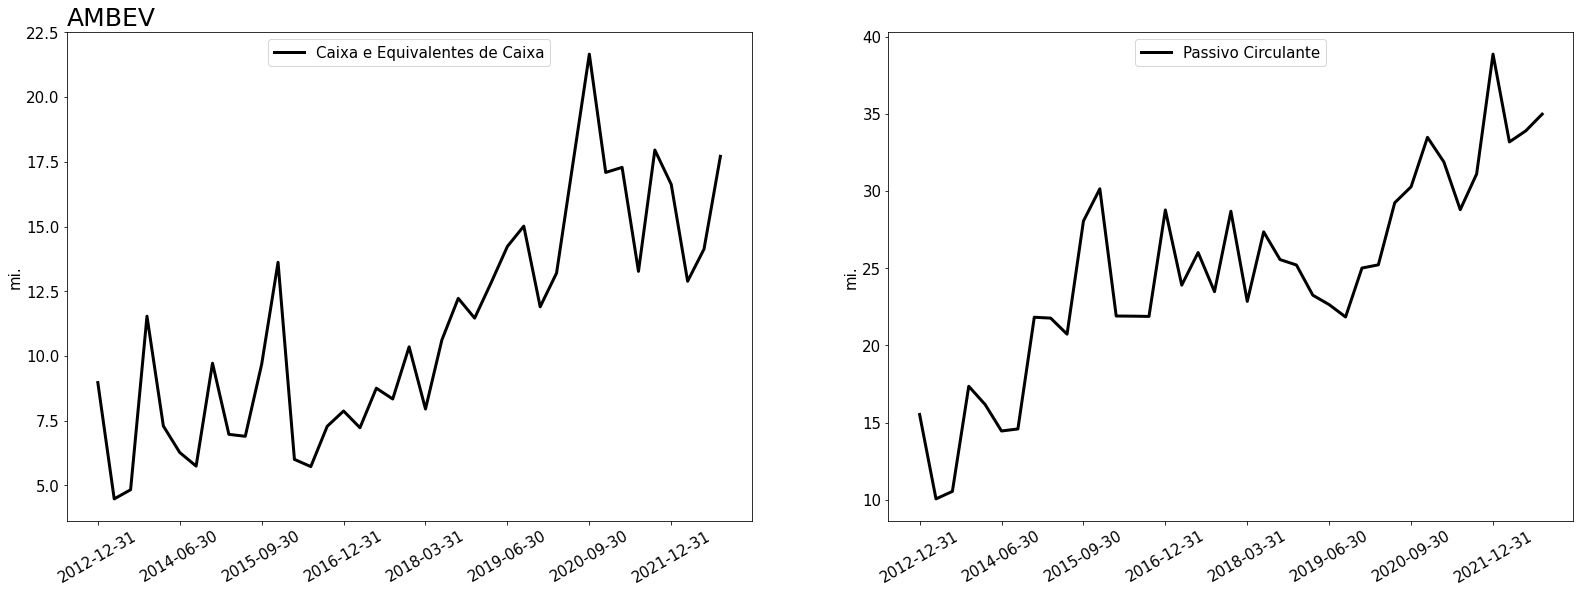

In [ ]:
plt.figure(figsize=(27, 9))
plt.subplot(1, 2, 1)
plt.title('AMBEV', loc='left', fontsize=25)
dados[0]['resultado'].plot(label='Caixa e Equivalentes de Caixa', color='black', linewidth=3)
plt.xlabel(None)
plt.legend(loc='upper center', fontsize=15)
plt.ylabel('mi.', fontsize=15)
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)
plt.subplot(1, 2, 2)
dados[1]['resultado'].plot(label='Passivo Circulante', color='black', linewidth=3)
plt.xlabel(None)
plt.legend(loc='upper center', fontsize=15)
plt.ylabel('mi.', fontsize=15)
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
balanco_ativo = [
    'Ativo Total',
    'Ativo Circulante',
    'Caixa e Equivalentes de Caixa',
    'Aplicações Financeiras',
    'Aplicações Financeiras Avaliadas a Valor Justo',
    'Títulos para Negociação',
    'Títulos Disponíveis para Venda',
    'Aplicações Financeiras Avaliadas ao Custo Amortizado',
    'Títulos Mantidos até o Vencimento',
    'Contas a Receber',
    'Clientes',
    'Outras Contas a Receber',
    'Estoques',
    'Ativos Biológicos',
    'Tributos a Recuperar',
    'Tributos Correntes a Recuperar',
    'Despesas Antecipadas',
    'Outros Ativos Circulantes',
    'Ativos Não-Correntes a Venda',
    'Ativos de Operações Descontinuadas',
    'Outros',
    'Ganhos não realizados com derivativos',
    'Créditos Tributários',
    'Ativo Não Circulante',
    'Ativo Realizável a Longo Prazo',
    'Tributos Diferidos',
    'Imposto de Renda e Contribuição Social Diferidos',
    'Créditos com Partes Relacionadas',
    'Créditos com Coligadas',
    'Créditos com Controladores',
    'Créditos com Outras Partes Relacionadas',
    'Outros Ativos Não Circulantes',
    'Créditos tributários',
    'Depósitos judiciais',
    'Gastos antecipados com plano de pensão',
    'Investimentos',
    'Participações Societárias',
    'Participações em Coligadas',
    'Outras Participações Societárias',
    'Propriedades para Investimento',
    'Imobilizado',
    'Imobilizado em Operação',
    'Imobilizado Arrendado',
    'Imobilizado em Andamento',
    'Intangível',
    'Intangíveis',
    'Contrato de Concessão',
    'Goodwill',
    'Adiantamento para futuro investimento em participação societária']

In [ ]:
balanco_passivo = [
    'Passivo Total',
    'Passivo Circulante',
    'Obrigações Sociais e Trabalhistas',
    'Obrigações Sociais',
    'Obrigações Trabalhistas',
    'Fornecedores',
    'Fornecedores Nacionais',
    'Fornecedores Estrangeiros',
    'Obrigações Fiscais',
    'Obrigações Fiscais Federais',
    'Imposto de Renda e Contribuição Social a Pagar',
    'Obrigações Fiscais Estaduais',
    'Obrigações Fiscais Municipais',
    'Empréstimos e Financiamentos',
    'Em Moeda Nacional',
    'Em Moeda Estrangeira',
    'Debêntures',
    'Financiamento por Arrendamento Financeiro',
    'Outras Obrigações',
    'Passivos com Partes Relacionadas',
    'Débitos com Coligadas',
    'Débitos com Controladores',
    'Débitos com Outras Partes Relacionadas',
    'Outros',
    'Dividendos e JCP a Pagar',
    'Dividendo Mínimo Obrigatório a Pagar',
    'Obrigações por Pagamentos Baseados em Ações',
    'Obrigações por compra de ações',
    'Outras contas a pagar',
    'Provisões',
    'Provisões Fiscais Previdenciárias Trabalhistas e Cíveis',
    'Provisões Fiscais',
    'Provisões Previdenciárias e Trabalhistas',
    'Provisões para Benefícios a Empregados',
    'Provisões Cíveis',
    'Outras Provisões',
    'Provisões para Garantias',
    'Provisões para Reestruturação',
    'Provisões para Passivos Ambientais e de Desativação',
    'Passivos sobre Ativos Não-Correntes a Venda e Descontinuados',
    'Passivos sobre Ativos Não-Correntes a Venda',
    'Passivos sobre Ativos de Operações Descontinuadas',
    'Passivo Não Circulante',
    'Adiantamento para Futuro Aumento de Capital',
    'Perdas não realizadas com derivativos',
    'Tributos Diferidos',
    'Imposto de Renda e Contribuição Social Diferidos',
    'Provisão para passivos tributários, cíveis e trabalhistas',
    'Provisão para passivos ambientais',
    'Lucros e Receitas a Apropriar',
    'Lucros a Apropriar',
    'Receitas a Apropriar',
    'Subvenções de Investimento a Apropriar',
    'Patrimônio Líquido Consolidado',
    'Capital Social Realizado',
    'Reservas de Capital',
    'Ágio na Emissão de Ações',
    'Reserva Especial de Ágio na Incorporação',
    'Alienação de Bônus de Subscrição',
    'Opções Outorgadas',
    'Ações em Tesouraria',
    'Outras Reservas',
    'Reservas de Reavaliação',
    'Reservas de Lucros',
    'Reserva Legal',
    'Reserva Estatutária',
    'Reserva para Contingências',
    'Reserva de Lucros a Realizar',
    'Reserva de Retenção de Lucros',
    'Reserva Especial para Dividendos Não Distribuídos',
    'Reserva de Incentivos Fiscais',
    'Dividendo Adicional Proposto',
    'Reserva Investimentos e Capital de Giro',
    'Lucros/Prejuízos Acumulados',
    'Ajustes de Avaliação Patrimonial',
    'Ajustes Acumulados de Conversão',
    'Outros Resultados Abrangentes',
    'Participação dos Acionistas Não Controladores',
    'Perdas não realizadas com instrumentos financeiros']

In [ ]:
# Algumas empresas é preciso alterar o nome.
lista_nome = [
    [["RRRP3"], ["PETROLEUM"]],
    [["ALSO3"], ["ALIANSCSONAE"]],
    [["ALPA4"], ["ALPARGATAS"]],
    [["ABEV3"], ["AMBEV"]],
    [["ARZZ3"], ["AREZZO"]],
    [["ASAI3"], ["ASSAI"]],
    [["AZUL4"], ["AZUL"]],
    [["B3SA3"], ["B3"]],
    [["BPAN4"], ["BANCO PAN"]],
    [["BBSE3"], ["BBSEGURIDADE"]],
    [["BBDC3"], ["BRADESCO"]],
    [["BBDC4"], ["BRADESCO"]],
    [["BRAP4"], ["BRADESPAR"]],
    [["BBAS3"], ["BRASIL"]],
    [["BRKM5"], ["BRASKEM"]],
    [["BRFS3"], ["BRF SA"]],
    [["BPAC11"], ["BTGP BANCO"]],
    [["CRFB3"], ["CARREFOUR BR"]],
    [["CCRO3"], ["CCR SA"]],
    [["CMIG4"], ["CEMIG"]],
    [["CIEL3"], ["CIELO"]],
    [["COGN3"], ["COGNA ON"]],
    [["CPLE6"], ["COPEL"]],
    [["CSAN3"], ["COSAN"]],
    [["CPFE3"], ["CPFL ENERGIA"]],
    [["CMIN3"], ["CSNMINERACAO"]],
    [["CVCB3"], ["CVC BRASIL"]],
    [["CYRE3"], ["CYRELA REALT"]],
    [["DXCO3"], ["DEXCO"]],
    [["ECOR3"], ["ECORODOVIAS"]],
    [["ELET3"], ["ELETROBRAS"]],
    [["ELET6"], ["ELETROBRAS"]],
    [["EMBR3"], ["EMBRAER"]],
    [["ENBR3"], ["ENERGIAS BR"]],
    [["ENGI11"], ["ENERGISA"]],
    [["ENEV3"], ["ENEVA"]],
    [["EGIE3"], ["ENGIE BRASIL"]],
    [["EQTL3"], ["EQUATORIAL"]],
    [["EZTC3"], ["EZTEC"]],
    [["FLRY3"], ["FLEURY"]],
    [["GGBR4"], ["GERDAU"]],
    [["GOAU4"], ["GERDAU MET"]],
    [["GOLL4"], ["GOL"]],
    [["NTCO3"], ["GRUPO NATURA"]],
    [["SOMA3"], ["GRUPO SOMA"]],
    [["HAPV3"], ["HAPVIDA"]],
    [["HYPE3"], ["HYPERA"]],
    [["IGTI11"], ["IGUATEMI"]],
    [["ITSA4"], ["ITAUSA"]],
    [["ITUB4"], ["ITAUUNIBANCO"]],
    [["JBSS3"], ["JBS"]],
    [["KLBN11"], ["KLABIN S/A"]],
    [["RENT3"], ["LOCALIZA"]],
    [["LWSA3"], ["LOCAWEB"]],
    [["LREN3"], ["LOJAS RENNER"]],
    [["MGLU3"], ["MAGAZ LUIZA"]],
    [["MRFG3"], ["MARFRIG"]],
    [["CASH3"], ["MELIUZ"]],
    [["BEEF3"], ["MINERVA"]],
    [["MRVE3"], ["MRV"]],
    [["MULT3"], ["MULTIPLAN"]],
    [["PCAR3"], ["P.ACUCAR-CBD"]],
    [["PETR3"], ["PETROBRAS"]],
    [["PETR4"], ["PETROBRAS"]],
    [["PRIO3"], ["PETRORIO"]],
    [["PETZ3"], ["PETZ"]],
    [["QUAL3"], ["QUALICORP"]],
    [["RADL3"], ["RAIADROGASIL"]],
    [["RAIZ4"], ["RAIZEN"]],
    [["RDOR3"], ["REDE D OR"]],
    [["RAIL3"], ["RUMO S.A."]],
    [["SBSP3"], ["SABESP"]],
    [["SANB11"], ["SANTANDER BR"]],
    [["SMTO3"], ["SAO MARTINHO"]],
    [["CSNA3"], ["SID NACIONAL"]],
    [["SLCE3"], ["SLC AGRICOLA"]],
    [["SUZB3"], ["SUZANO S.A."]],
    [["TAEE11"], ["TAESA"]],
    [["VIVT3"], ["TELEF BRASIL"]],
    [["TIMS3"], ["TIM"]],
    [["TOTS3"], ["TOTVS"]],
    [["UGPA3"], ["ULTRAPAR"]],
    [["USIM5"], ["USIMINAS"]],
    [["VALE3"], ["VALE"]],
    [["VIIA3"], ["VIA"]],
    [["VBBR3"], ["VIBRA"]],
    [["WEGE3"], ["WEG"]],
    [["YDUQ3"], ["YDUQS PART"]]
    ]